In [1]:
import numpy as np

class GaussianSystem:
    """
    This class implements several methods for describing a driven-dissipative
    bosonic lattice. In particular, it describes a set of N bosonic modes
    coupled to a chiral multi-mode waveguide in the linear regime.

    Methods include a routine to find steady state correlations and topological
    features of the doubled-Hamiltonian.
    """

    def __init__(self, N):
        self.N = N

    def create_params(self, Gammas, kl_s, pump, g_s, l_k, Delta=0, g_c=0):
        """
        Creates a dictionary 'params' with all the relevant parameters of the
        system:

            - Gammas: List of decay rates to each chiral mode
            - kl_s: List of momenta of each chiral mode
            - pump: Amplitude of incoherent pump
            - g_s: Parametric driving
            - positions: List of positions of the bosonic modes
        """
        params = {}
        params['Gammas'] = Gammas
        params['kl_s'] = kl_s
        params['pump'] = pump
        params['g_s'] = g_s
        params['l_k'] = l_k
        params['Delta'] = Delta
        params['g_c'] = g_c

        return params

    def get_H_nh_k_space(self, k, params):
        """
        Gets the 2x2 matrix representing the non-Hermitian Hamiltonian acting
        over the Nambu spinor (b_k, b^dagger_k) in momentum space, for our
        chiral-multimode scenario

        Parameters
        ----------
        k: float
          Momentum at which H_nk(k) is evaluated

        params : Dictionary
              System parameters

        Returns
        -------
        H_nh : Matrix
            2x2 Non-Hermitian matrix
        """

        # Retrieve parameters from input dictionary
        pump = params['pump']       # Incoherent pump amplitude
        Gammas = params['Gammas']   # Decay rates onto each mode
        kl_s = params['kl_s']       # Momentum of each mode
        g_s = params['g_s']         # Parametric driving
        l_k = params['l_k']         # Dissipative length
        Delta = params['Delta']     # Parametric drive detuning
        g_c = params['g_c']         # Collective parametric driving

        # Convert to numpy arrays to allow operations
        Gammas, kl_s = np.array(Gammas), np.array(kl_s)

        # Initialize matrix
        H_nh = np.zeros((2,2), dtype=complex)

        # Parametric driving
        H_nh[0,1] = g_s + 2*g_c*np.cos(k)
        H_nh[1,0] = -np.conjugate(g_s) -2*np.conjugate(g_c)*np.cos(k)

        # Incoherent pump
        H_nh[0,0]= 1j*pump/2
        H_nh[1,1]= 1j*pump/2

        # Local losses
        H_nh[0,0]+= -1j*np.sum(Gammas/2)
        H_nh[1,1]+= -1j*np.sum(Gammas/2)

        # Collective losses
        H_nh[0,0] += -1j*np.sum(Gammas*np.exp(1j*(k+kl_s)-1/l_k)/(1-np.exp(1j*(k+kl_s)-1/l_k)))
        H_nh[1,1] += -1j*np.sum(Gammas*np.exp(1j*(k-kl_s)-1/l_k)/(1-np.exp(1j*(k-kl_s)-1/l_k)))

        # Parametric drive detuning
        H_nh[0,0] += Delta
        H_nh[1,1] += -Delta

        return H_nh

    def h(self, k, params):
        H_nh = self.get_H_nh_k_space(k, params)
        h_k = H_nh[0,0]

        return h_k

In [2]:
def get_params(W, Delta_pi=False):
    """
    Function to get a set of parameters leading to a winding number corresponding
    to input W. The keyword argument Delta_pi, if true, considers a two-mode waveguide
    where (k1-k0) is equal to pi.
    """
    Gauss = GaussianSystem(10)

    g_s = 0.0

    if W == 0:

        Gammas = [1]
        kl_s = [0]
        l_k = 10
        pump = 0.0

    else:

        Gammas = (1/W)*np.ones((W))
        kl_s = np.array([0, np.pi/4, np.pi/8])[:W]
        l_k = 1000
        pump = 0.2

    if Delta_pi:

        Gammas = [1/2,1/2]
        kl_s=[0, np.pi]
        l_k = 1000
        pump=0.2

    params = Gauss.create_params(Gammas, kl_s, pump, g_s, l_k)

    return params

In [3]:
def compute_expression(params, N):

    Gauss = GaussianSystem(N)
    h = lambda k: Gauss.h(k, params)

    # Discretize k-space from -pi to pi with N points
    k = np.linspace(-np.pi, np.pi, N, endpoint=False)

    # Initialize the list to store the result
    result = np.zeros(N)

    # Finite difference step size
    delta_k = 2 * np.pi / N

    # Loop over each k_n and compute the expression
    for n in range(1, N-1):  # We use n-1 and n+1, so avoid boundaries
        h_prime = (h(k[n+1]) - h(k[n-1])) / (2 * delta_k)  # Central difference approximation
        result[n] = np.abs(h_prime / h(k[n])) * delta_k

    return result

In [4]:
N = 25
params = get_params(1)

(-1.0, 1.0)

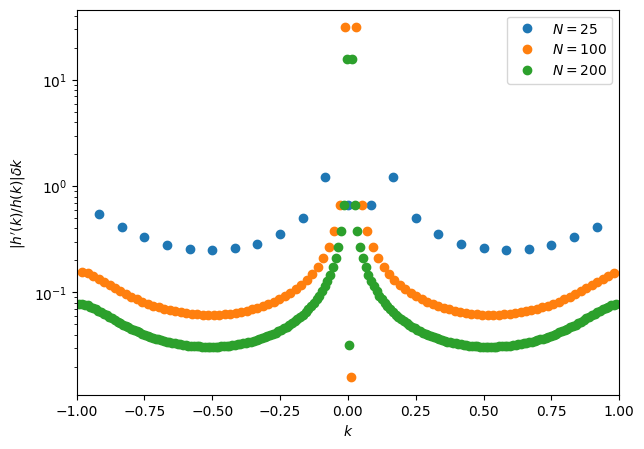

In [ ]:
import matplotlib.pyplot as plt

Ns = [25, 100, 200]

fig, ax = plt.subplots(figsize = (7,5))
ax.plot(np.linspace(-np.pi, np.pi, Ns[0])/np.pi, compute_expression(params, Ns[0]), 'o', label="$N=25$")
ax.plot(np.linspace(-np.pi, np.pi, Ns[1])/np.pi, compute_expression(params, Ns[1]), 'o', label="$N=100$")
ax.plot(np.linspace(-np.pi, np.pi, Ns[2])/np.pi, compute_expression(params, Ns[2]), 'o', label="$N=200$")
ax.set_yscale('log')
ax.legend()
ax.set_xlabel("$k$")
ax.set_ylabel("$|h'(k)/h(k)|\delta k$")
ax.set_xlim([-1, 1])